<a href="https://colab.research.google.com/github/martinaturchini/HIV-1-cleavege-/blob/main/hiv_cleavage_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras.optimizers import optimizer, Adam
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from keras.callbacks import Callback, ModelCheckpoint
from keras.regularizers import l2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import itertools

In [ ]:
#uploading the data into a dataframe

file_dir = '/content/gdrive/My Drive'

df_original = pd.read_excel(f"{file_dir}/12859_2022_5017_MOESM2_ESM.xlsx")

In [ ]:
df=df_original

display(df)

df = df.iloc[:,1:]

,octamer,A1,C1,D1,E1,F1,G1,H1,I1,K1,...,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,PCP_NE_pH,PCP_HB,PCP_HL,PCP_SC,cleavage Status
0,AECFRIFD,1,0,0,0,0,0,0,0,0,...,0.250,0.000,0.250,0.250,0.125,0.625,0.625,0.125,0.125,1
1,HLVEALYL,0,0,0,0,0,0,1,0,0,...,0.625,0.000,0.125,0.125,0.125,0.750,0.625,0.125,0.000,1
2,TQIMFETF,0,0,0,0,0,0,0,0,0,...,0.125,0.000,0.250,0.125,0.000,0.875,0.750,0.000,0.125,1
3,AEELAEIF,1,0,0,0,0,0,0,0,0,...,0.500,0.000,0.125,0.375,0.000,0.625,0.625,0.000,0.000,1
4,PFIFEEEP,0,0,0,0,0,0,0,0,0,...,0.375,0.250,0.250,0.375,0.000,0.625,0.625,0.250,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5843,YVPVTTFK,0,0,0,0,0,0,0,0,0,...,0.375,0.125,0.250,0.000,0.125,0.875,0.750,0.250,0.000,0
5844,YVQQHGGV,0,0,0,0,0,0,0,0,0,...,0.500,0.000,0.125,0.000,0.125,0.875,0.250,0.125,0.000,0
5845,YVSNIDGT,0,0,0,0,0,0,0,0,0,...,0.375,0.000,0.125,0.125,0.000,0.875,0.375,0.125,0.000,0
5846,YWPQEAGE,0,0,0,0,0,0,0,0,0,...,0.375,0.125,0.250,0.250,0.000,0.750,0.375,0.125,0.000,0


Number of non-cleaved sequences: 4847
Number of cleaved sequences: 1001
The data set is imbalanced


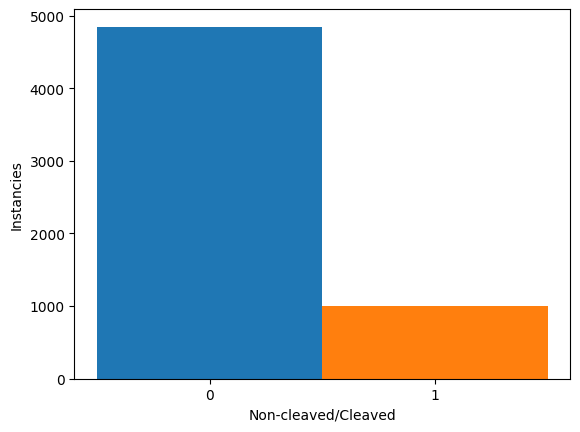

In [ ]:
#show the data distribution (occurences of 1,-1) in a plot
num_cleaved = df['cleavage Status'][df['cleavage Status'] == 1].count()
num_noncleaved = df['cleavage Status'][df['cleavage Status'] == 0].count()

df.groupby('cleavage Status')['cleavage Status'].hist(bins = 1)
plt.xlabel("Non-cleaved/Cleaved")
plt.xticks([0, 1])
plt.grid(False)
plt.ylabel("Instancies")

print('Number of non-cleaved sequences:', num_noncleaved)
print('Number of cleaved sequences:', num_cleaved)
print('The data set is imbalanced')

In [ ]:
df_X = df[df.columns[:178]]
df_y = df[df.columns[-1]]

X = df_X.to_numpy()
y = df_y.to_numpy()

X = MinMaxScaler().fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=42, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.33, shuffle=True, random_state=42,
    stratify=y_test)

In [ ]:
train_df = pd.DataFrame(X_train, columns = df_X.columns)
train_df['cleavage Status'] = y_train

cleaved_train_df = train_df.loc[train_df['cleavage Status'] == 1]

# Cleaved entries (minority class) are 851 in the train set
non_cleaved_train_df = train_df.loc[train_df['cleavage Status'] == 0].sample(
    n=851, random_state=42)

# Concatenate both dataframes again
equalized_train_df = pd.concat([non_cleaved_train_df, cleaved_train_df])

display(equalized_train_df)

,A1,C1,D1,E1,F1,G1,H1,I1,K1,L1,...,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,PCP_NE_pH,PCP_HB,PCP_HL,PCP_SC,cleavage Status
1071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.375,0.00,0.00,0.125,0.500000,0.500,0.375,0.428571,0.000000,0
3219,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500,0.00,0.25,0.000,0.000000,1.000,0.375,0.000000,0.000000,0
3272,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.750,0.00,0.00,0.125,0.000000,0.875,0.500,0.000000,0.000000,0
2716,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.625,0.00,0.25,0.125,0.000000,0.875,0.375,0.000000,0.000000,0
3033,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.375,0.00,0.00,0.125,0.500000,0.500,0.125,0.428571,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.625,0.25,0.00,0.000,0.000000,1.000,0.875,0.142857,0.333333,1
4953,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.125,0.00,0.25,0.125,0.166667,0.750,0.375,0.285714,0.000000,1
4959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.250,0.25,0.00,0.250,0.000000,0.750,0.375,0.142857,0.333333,1
4961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500,0.25,0.00,0.250,0.166667,0.625,0.625,0.285714,0.000000,1


Number of non-cleaved sequences in the training set: 851
Number of cleaved sequences in the training set: 851
Now the training set is balanced
Number of non-cleaved sequences in the validation set: 240
Number of cleaved sequences in the validation set: 50
Number of non-cleaved sequences in the test set: 488
Number of cleaved sequences in the test set: 100


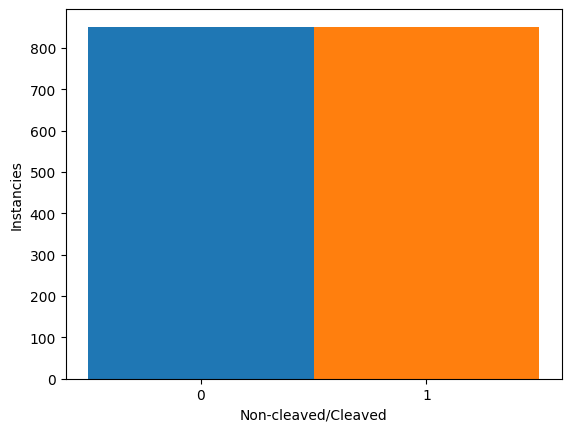

In [ ]:
num_cleaved_eq = equalized_train_df['cleavage Status'][equalized_train_df['cleavage Status'] == 1].count()
num_noncleaved_eq = equalized_train_df['cleavage Status'][equalized_train_df['cleavage Status'] == 0].count()

equalized_train_df.groupby('cleavage Status')['cleavage Status'].hist(bins = 1)
plt.xlabel("Non-cleaved/Cleaved")
plt.xticks([0, 1])
plt.grid(False)
plt.ylabel("Instancies")

print('Number of non-cleaved sequences in the training set:', num_noncleaved_eq)
print('Number of cleaved sequences in the training set:', num_cleaved_eq)
print('Now the training set is balanced')

print('Number of non-cleaved sequences in the validation set:',
      np.count_nonzero(y_val==0))
print('Number of cleaved sequences in the validation set:',
      np.count_nonzero(y_val==1))

print('Number of non-cleaved sequences in the test set:',
      np.count_nonzero(y_test==0))
print('Number of cleaved sequences in the test set:',
      np.count_nonzero(y_test==1))

In [ ]:
X_train = equalized_train_df[equalized_train_df.columns[:178]].to_numpy()
y_train = equalized_train_df[equalized_train_df.columns[-1]].to_numpy()

# Method 1: DNN

##Hyperparameter optimization

In [ ]:
param_space = {
    'dropout': [0, 0.2, 0.4],
    'l2_lambda': [0, 0.001, 0.01],
    'learning_rate': [0.001, 0.0001],
    'dense_nodes': [[8],[16],[32],[64],[128],
                    [8,4],[16,8],[32,16],[64,32]]
}

value_combis = itertools.product(*[v for v in param_space.values()])

# List comprehension short form:
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

class HistoryEpoch(Callback):
    def __init__(self, data):
        self.data = data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        logs['train_loss'] = l
        logs['train_accuracy'] = a

search_results = []

# reuse from before:
for idx, params in enumerate(param_combis):

    optimizer = Adam(learning_rate=params['learning_rate'])

    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")

    model = Sequential()
    model.add(InputLayer(X_train[0].shape))

    for nodes in params['dense_nodes']:
      model.add(Dense(nodes, activation='relu',
                      kernel_regularizer=l2(params['l2_lambda'])))
      model.add(Dropout(params['dropout']))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    ########################################

    # we choose our best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=0,
        save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=X_train,
      y=y_train,
      batch_size=64,
      epochs=30,
      validation_data=(X_val, y_val),
      callbacks=[checkpoint, HistoryEpoch((X_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    train_loss_at_best_val_acc = fit_results.history['train_loss'][best_val_epoch]
    train_acc_at_best_val_acc = fit_results.history['train_accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'train_acc_at_best_val_acc': train_acc_at_best_val_acc,
        'best_val_acc': best_val_acc,
        'train_loss_at_best_val_acc': train_loss_at_best_val_acc,
        'best_val_acc_loss': best_val_acc_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })

We have a total of 162 combinations:
[{'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [8]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [16]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [32]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [64]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [128]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [8, 4]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [16, 8]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [32, 16]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [64, 32]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.0001, 'dense_nodes': [8]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.0001, 'dense_nodes': [16]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.0001, 'dense_nodes': [32]}, {'dropout': 0, 'l2_lamb

In [ ]:
# which combinations perform best?

df_results = pd.DataFrame(search_results).sort_values(
    'best_val_acc', ascending=False)

# removing the only one critical hyperparameter set
df_results = df_results[df_results['train_acc_at_best_val_acc']>0.7]
df_results = df_results[df_results['best_val_acc']>0.7]

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df_results)

,dropout,l2_lambda,learning_rate,dense_nodes,train_acc_at_best_val_acc,best_val_acc,train_loss_at_best_val_acc,best_val_acc_loss,best_val_epoch,history
39,0.0,0.010,1.000e-03,[64],0.931,0.914,0.285,0.296,18,"{'loss': [1.4330153465270996, 1.08038568496704..."
147,0.4,0.010,1.000e-03,[64],0.935,0.914,0.277,0.302,23,"{'loss': [1.432857871055603, 1.100283741950988..."
90,0.2,0.010,1.000e-03,[8],0.810,0.914,0.640,0.577,3,"{'loss': [0.8203539848327637, 0.77125746011734..."
114,0.4,0.000,1.000e-03,"[16, 8]",0.938,0.914,0.194,0.270,16,"{'loss': [0.6913630962371826, 0.67152619361877..."
40,0.0,0.010,1.000e-03,[128],0.931,0.910,0.276,0.288,18,"{'loss': [1.8192641735076904, 1.23740625381469..."
98,0.2,0.010,1.000e-03,"[64, 32]",0.934,0.910,0.326,0.356,12,"{'loss': [1.8364278078079224, 1.41154980659484..."
94,0.2,0.010,1.000e-03,[128],0.933,0.910,0.275,0.293,18,"{'loss': [1.84111750125885, 1.2691729068756104..."
44,0.0,0.010,1.000e-03,"[64, 32]",0.937,0.910,0.294,0.333,17,"{'loss': [1.808763861656189, 1.367272615432739..."
132,0.4,0.001,1.000e-03,"[16, 8]",0.952,0.910,0.204,0.292,21,"{'loss': [0.7296810150146484, 0.71911627054214..."
24,0.0,0.001,1.000e-03,"[16, 8]",0.931,0.910,0.235,0.267,9,"{'loss': [0.728543221950531, 0.690034806728363..."


In [ ]:
df_results['delta_acc'] = (df_results['train_acc_at_best_val_acc']-df_results['best_val_acc'])/df_results['best_val_acc']

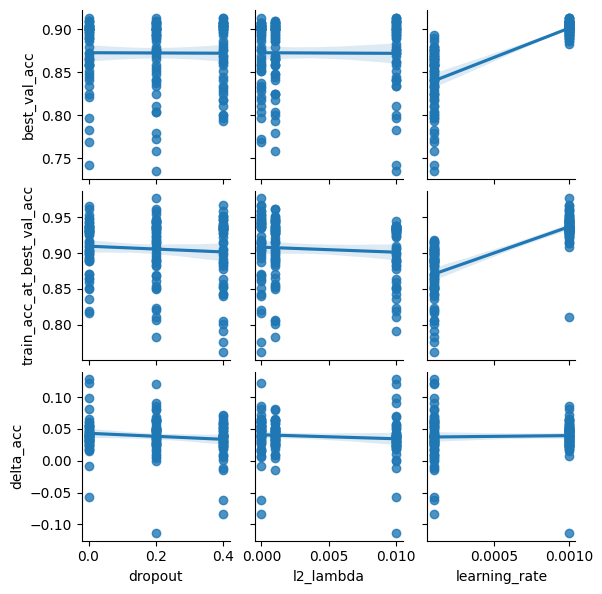

In [ ]:
sns.pairplot(df_results,
             x_vars=['dropout', 'l2_lambda', 'learning_rate'],
             y_vars=['best_val_acc', 'train_acc_at_best_val_acc', 'delta_acc'],
             kind='reg', height=2)

plt.savefig(f"{file_dir}/HIV-CP Plots/Gridsearch Pairplot.pdf")
plt.show()

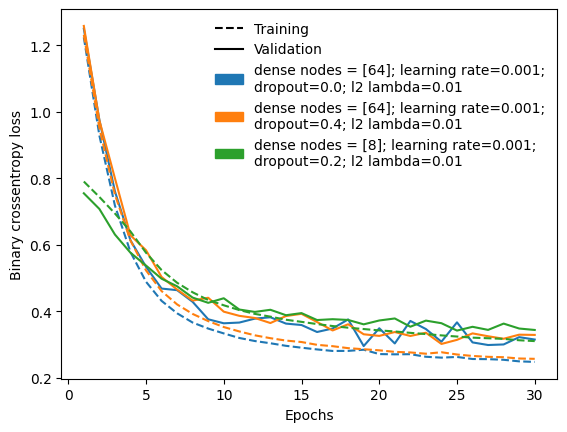

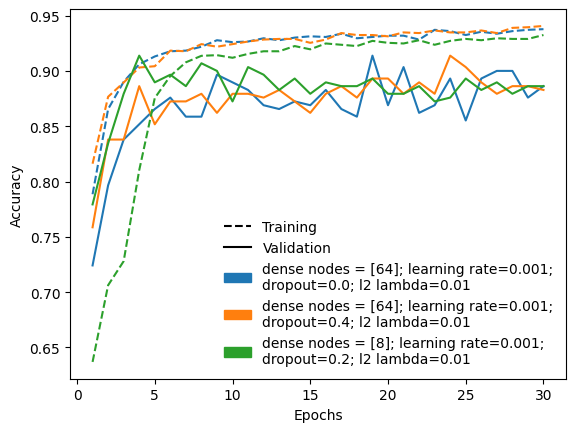

In [ ]:
# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df_results.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"dense nodes = {row_series['dense_nodes']}; learning rate={row_series['learning_rate']};\ndropout={row_series['dropout']}; l2 lambda={row_series['l2_lambda']}"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)

plt.xlabel('Epochs')
plt.xticks(np.arange(0,32,step=5))
plt.ylabel('Binary crossentropy loss')

plt.legend(frameon=False)
plt.savefig(f"{file_dir}/HIV-CP Plots/Loss Gridsearch.pdf")
plt.show()


# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df_results.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_accuracy'])+1)
  parameter_combination_string = f"dense nodes = {row_series['dense_nodes']}; learning rate={row_series['learning_rate']};\ndropout={row_series['dropout']}; l2 lambda={row_series['l2_lambda']}"
  plt.plot(x, row_series['history']['train_accuracy'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_accuracy'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.xticks(np.arange(0,32,step=5))
plt.ylabel('Accuracy')

plt.legend(frameon=False)
plt.savefig(f"{file_dir}/HIV-CP Plots/Accuracy Gridsearch.pdf")
plt.show()

##Models

In [ ]:
def compare_history(network_history1, batch_size1,
                    network_history2, batch_size2,
                    mod_num):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history1.history['loss'], '--', color='orange')
    plt.plot(network_history1.history['val_loss'], '-', color='orange')
    plt.plot(network_history2.history['loss'], '--', color='green')
    plt.plot(network_history2.history['val_loss'], '-', color='green')
    plt.legend(['Training_'+ batch_size1, 'Validation_'+ batch_size1,
                'Training_'+ batch_size2, 'Validation_'+ batch_size2],
               frameon=False)
    plt.savefig(f"{file_dir}//HIV-CP Plots/Loss MLP "+mod_num+".pdf")

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history1.history['accuracy'], '--', color='orange')
    plt.plot(network_history1.history['val_accuracy'], '-', color='orange')
    plt.plot(network_history2.history['accuracy'], '--', color='green')
    plt.plot(network_history2.history['val_accuracy'], '-', color='green')
    plt.legend(['Training_'+ batch_size1, 'Validation_'+ batch_size1,
                'Training_'+ batch_size2, 'Validation_'+ batch_size2],
               frameon=False)
    plt.savefig(f"{file_dir}//HIV-CP Plots/Accuracy MLP "+mod_num+".pdf")

    plt.show()


def plot_history(network_history, mod_num):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'], '--')
    plt.plot(network_history.history['val_loss'], '-')
    plt.legend(['Training', 'Validation'],
               frameon=False)
    plt.savefig(f"{file_dir}//HIV-CP Plots/Loss MLP "+mod_num+".pdf")

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'], '--')
    plt.plot(network_history.history['val_accuracy'], '-')
    plt.legend(['Training', 'Validation'],
               loc='lower right', frameon=False)
    plt.savefig(f"{file_dir}//HIV-CP Plots/Accuracy MLP "+mod_num+".pdf")

    plt.show()

In [ ]:
class HistoryEpoch(Callback):
    def __init__(self, data):
        self.data = data

    def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        self.loss.append(l)
        self.acc.append(a)

train_hist=HistoryEpoch((X_train, y_train))
val_hist=HistoryEpoch((X_val, y_val))
test_hist=HistoryEpoch((X_test, y_test))

In [ ]:
learning_rate = 0.001
l2_lambda = 0.01
dropout = 0.4
optimizer = Adam(learning_rate=learning_rate)

model1 = Sequential([
      Dense(16, activation='relu', kernel_regularizer=l2(l2_lambda),
            input_dim=178),
      Dropout(dropout),
      Dense(8, activation='relu', kernel_regularizer=l2(l2_lambda)),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model1.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
model1.summary()

history1 = model1.fit(x=X_train, y=y_train, batch_size=32, epochs=50,
                      validation_data=(X_val, y_val),
                      callbacks=[val_hist, train_hist, test_hist])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                2864      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
54/54 [==============================] - 1s

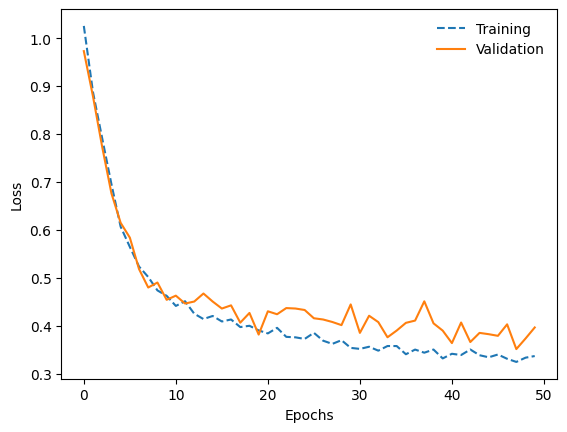

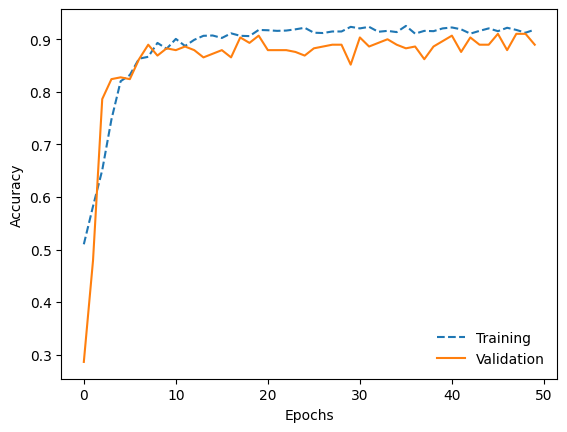

In [ ]:
plot_history(history1, '1')

In [ ]:
learning_rate = 0.001
l2_lambda = 0.01
dropout = 0.4
optimizer = Adam(learning_rate=learning_rate)

model2 = Sequential([
      Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda),
            input_dim=178),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model2.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
model2.summary()

history2 = model2.fit(x=X_train, y=y_train, batch_size=64, epochs=40,
                      validation_data=(X_val, y_val),
                      callbacks=[val_hist, train_hist, test_hist])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                11456     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
27/27 [==============================] - 1s 32ms/step - loss: 1.4775 - accuracy: 0.5576 - val_loss: 1.3106 - val_accuracy: 0.6379
Epoch 2/40
27/27 [==============================] - 0s 16ms/step - loss: 1.1425 - accuracy: 0.7374 - val_loss: 1.0339 - val_accuracy: 0.7414
Epoch 3/40
27/27 [==============

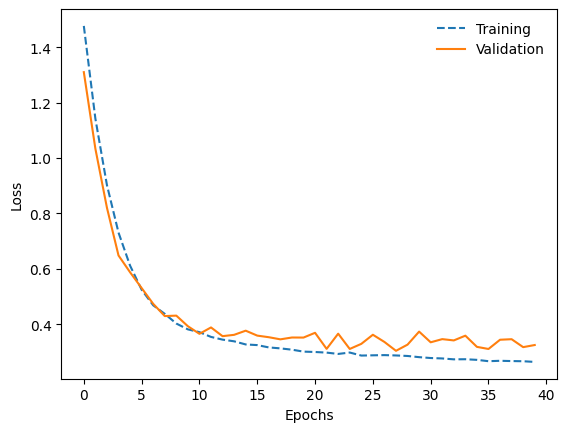

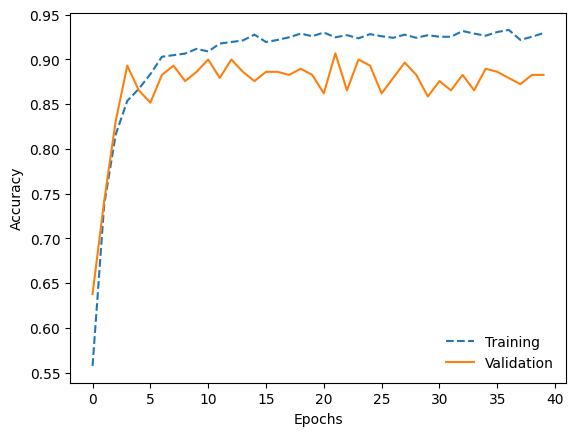

In [ ]:
plot_history(history2,'2')

In [ ]:
learning_rate = 0.001
l2_lambda = 0.01

optimizer = Adam(learning_rate=learning_rate)

model3 = Sequential([
      Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda),
            input_dim=178),
      Dense(1, activation='sigmoid')
      ])

model3.compile(loss='binary_crossentropy', optimizer=optimizer,
               metrics=['accuracy'])
model3.summary()

history3 = model3.fit(x=X_train, y=y_train, batch_size=64, epochs=40,
                      validation_data=(X_val, y_val))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                11456     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
27/27 [==============================] - 1s 7ms/step - loss: 1.4426 - accuracy: 0.6210 - val_loss: 1.2692 - val_accuracy: 0.6517
Epoch 2/40
27/27 [==============================] - 0s 3ms/step - loss: 1.0888 - accuracy: 0.8249 - val_loss: 0.9771 - val_accuracy: 0.7931
Epoch 3/40
27/27 [==============================] - 0s 3ms/step - loss: 0.8336 - accuracy: 0.8690 - val_loss: 0.7350 - val_accuracy: 0.8793
Epoch 4/40
27/27 [========

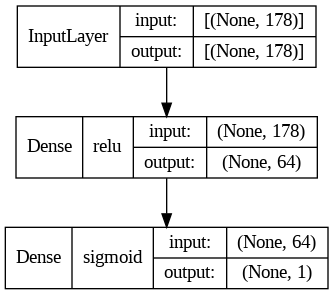

In [ ]:
from IPython.display import Image
from keras.utils.vis_utils import plot_model
plot_model(model3, to_file='model_plot.png', show_shapes=True,
           show_layer_names=False, show_layer_activations=True)
Image('model_plot.png')

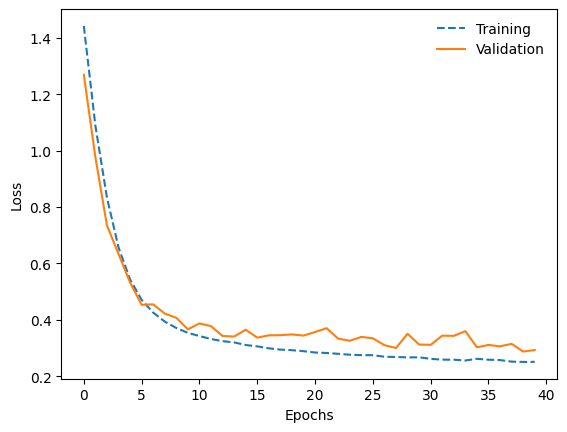

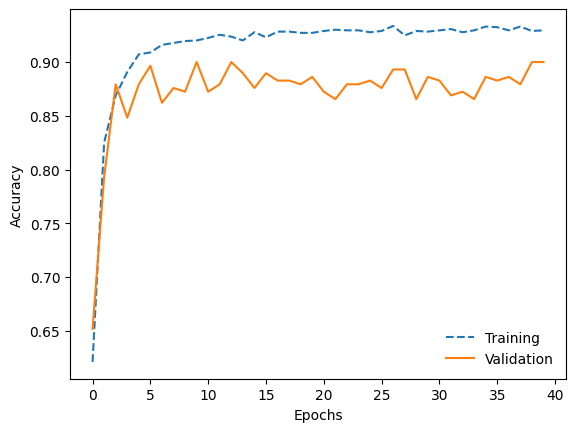

In [ ]:
plot_history(history3,'3')

In [ ]:
learning_rate = 0.001
l2_lambda = 0.01
dropout = 0.4

optimizer = Adam(learning_rate=learning_rate)

model4 = Sequential([
      Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda),
            input_dim=178),
      Dropout(dropout),
      Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda)),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model4.compile(loss='binary_crossentropy', optimizer=optimizer,
               metrics=['accuracy'])
model4.summary()

history4 = model4.fit(x=X_train, y=y_train, batch_size=64, epochs=40,
                      validation_data=(X_val, y_val),
                      callbacks=[val_hist, train_hist, test_hist])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                11456     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,569
Trainable params: 13,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
27/27 [==============================] 

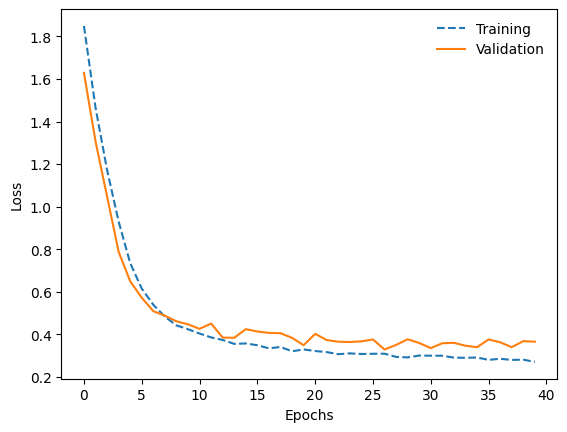

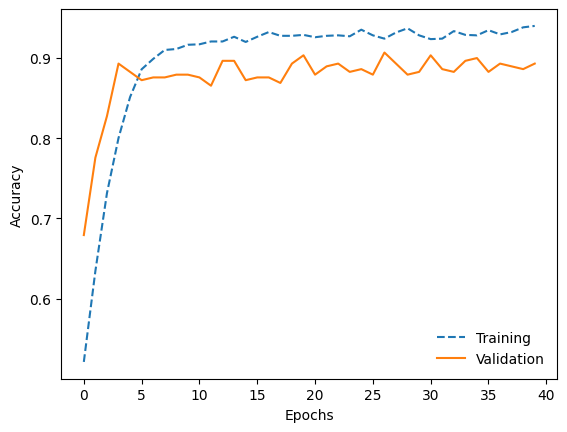

In [ ]:
plot_history(history4,'4')

In [ ]:
learning_rate = 0.001
l2_lambda = 0.01
dropout = 0.2

optimizer = Adam(learning_rate=learning_rate)

model5 = Sequential([
      Dense(8, activation='relu', kernel_regularizer=l2(l2_lambda),
            input_dim=178),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model5.compile(loss='binary_crossentropy', optimizer=optimizer,
               metrics=['accuracy'])
model5.summary()

history5 = model5.fit(x=X_train, y=y_train, batch_size=32, epochs=60,
                      validation_data=(X_val, y_val),
                      callbacks=[val_hist, train_hist, test_hist])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 1432      
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
54/54 [==============================] - 1s 8ms/step - loss: 0.7711 - accuracy: 0.6334 - val_loss: 0.6949 - val_accuracy: 0.7448
Epoch 2/60
54/54 [==============================] - 0s 7ms/step - loss: 0.6518 - accuracy: 0.7620 - val_loss: 0.5658 - val_accuracy: 0.8552
Epoch 3/60
54/54 [==================

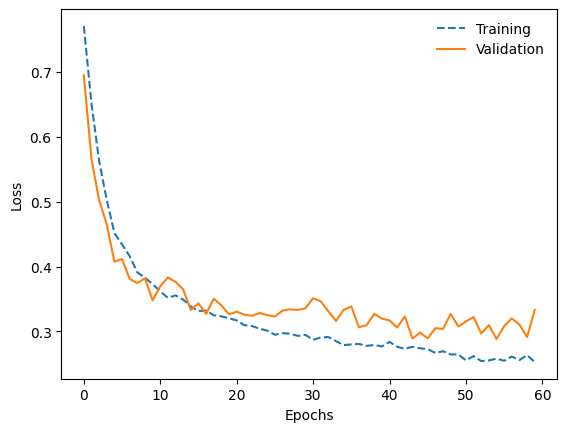

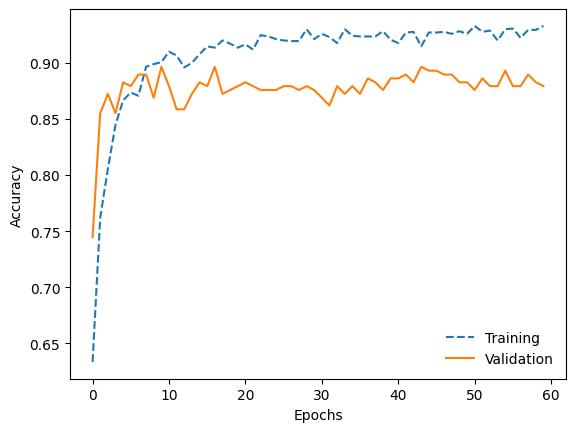

In [ ]:
plot_history(history5,'5')

##Evaluation



In [ ]:
def plot_confusion_matrix(cm, classes, method,
                          normalize=False,
                          title='Confusion matrix ',
                          cmap=plt.cm.Blues, mod_num=""):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + method + mod_num)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.savefig(f"{file_dir}//HIV-CP Plots/Confusion matrix "+
                method + mod_num + ".pdf")
    plt.show()

In [ ]:
def evaluate(x_test, Y_test, model, mod_num):

    ##Evaluate loss and metrics
    loss, accuracy = model.evaluate(x_test, Y_test, verbose=0)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)
    # Predict the values from the test dataset
    Y_pred = model.predict(x_test)

    Y_cls = [0]
    for i in range(len(Y_pred)):
      if Y_pred[i] <= 0.5:
        Y_cls = np.append(Y_cls,0)
      else:
        Y_cls = np.append(Y_cls,1)
    Y_cls = Y_cls[1:]

    cr = classification_report(Y_test, Y_cls, output_dict=True)
    print('Classification Report:\n', classification_report(Y_test,Y_cls))

    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_test, Y_cls)

    tn=confusion_mtx[0][0]
    fp=confusion_mtx[0][1]
    fn=confusion_mtx[1][0]
    tp=confusion_mtx[1][1]

    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    f1 = cr['weighted avg']['f1-score']

    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

    print('AUC:', auc(fpr,tpr))
    print('Sensitivity:', sensitivity)
    print('Specificity:', specificity)
    print('Average of performance metrics:',
          (accuracy+sensitivity+specificity+auc(fpr,tpr)+f1)/5)

    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = (0,1), method="MLP ",
                          mod_num=mod_num)

    disp = ConfusionMatrixDisplay.from_predictions(Y_test,Y_cls,
                                                   display_labels=(0,1),
                                                   cmap=plt.cm.Blues,
                                                   normalize='true')

    disp.ax_.set_title("Normalized confusion matrix MLP "+mod_num)

    plt.savefig(f"{file_dir}//HIV-CP Plots/Normalized confusion matrix MLP "+
                mod_num + ".pdf")
    plt.show()

    #create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Test Loss: 0.34828415513038635
Test Accuracy: 0.9064626097679138
19/19 [==============================] - 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       488
           1       0.66      0.92      0.77       100

    accuracy                           0.91       588
   macro avg       0.82      0.91      0.86       588
weighted avg       0.93      0.91      0.91       588

AUC: 0.9671106557377049
Sensitivity: 0.92
Specificity: 0.9036885245901639
Sum of performance metrics: 0.9218818944952905


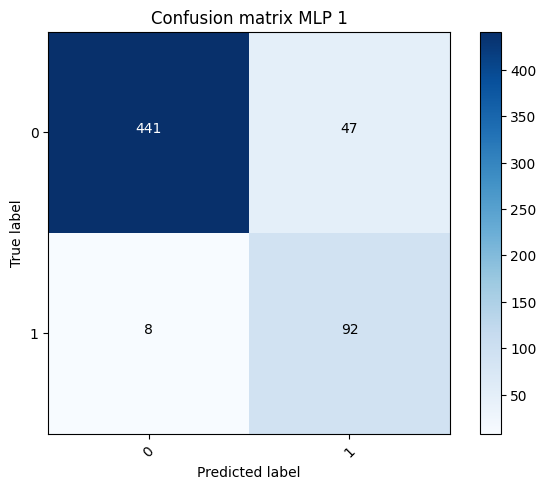

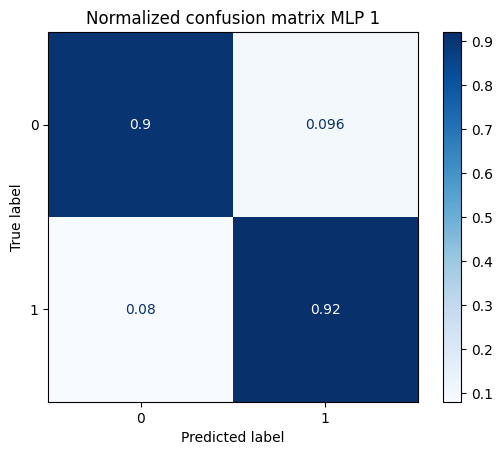

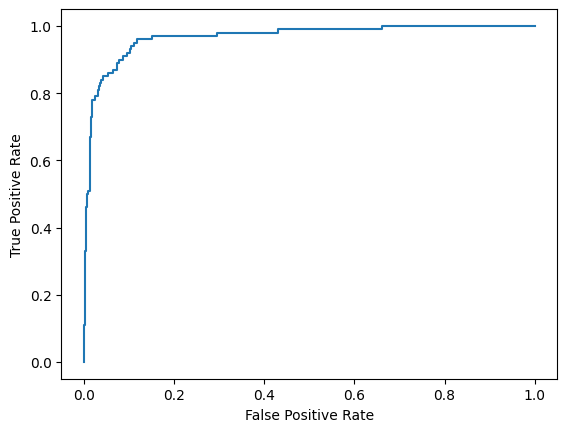

In [ ]:
evaluate(X_test, y_test, model1, '1')

Test Loss: 0.2846895158290863
Test Accuracy: 0.9132652878761292
19/19 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.95       488
           1       0.68      0.93      0.78       100

    accuracy                           0.91       588
   macro avg       0.83      0.92      0.87       588
weighted avg       0.93      0.91      0.92       588

AUC: 0.9657377049180328
Sensitivity: 0.93
Specificity: 0.9098360655737705
Sum of performance metrics: 0.927433192736838


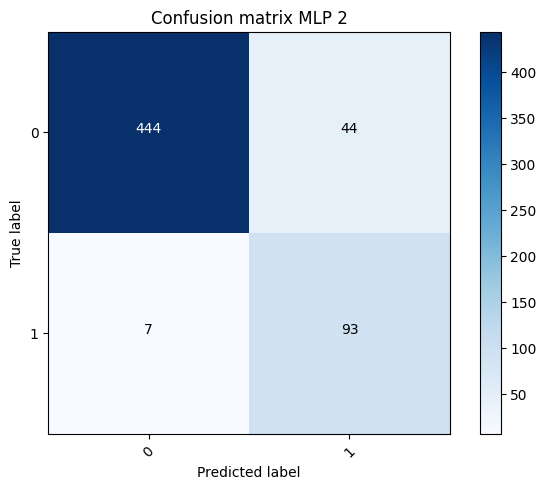

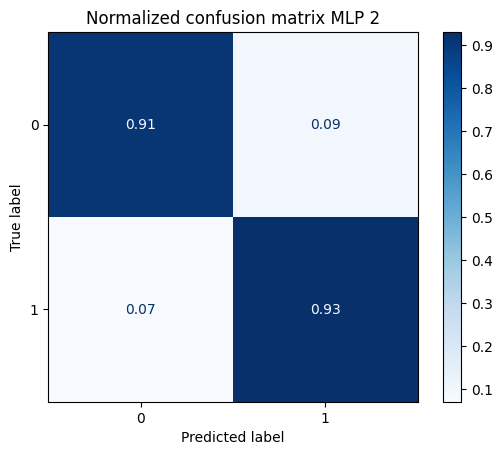

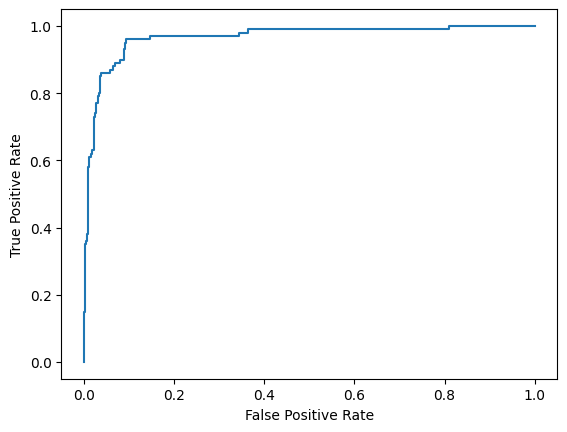

In [ ]:
evaluate(X_test, y_test, model2, '2')

Test Loss: 0.2574152946472168
Test Accuracy: 0.9251700639724731
19/19 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       488
           1       0.73      0.90      0.80       100

    accuracy                           0.93       588
   macro avg       0.85      0.92      0.88       588
weighted avg       0.94      0.93      0.93       588

AUC: 0.9641598360655738
Sensitivity: 0.9
Specificity: 0.930327868852459
Average of performance metrics: 0.929578669767354


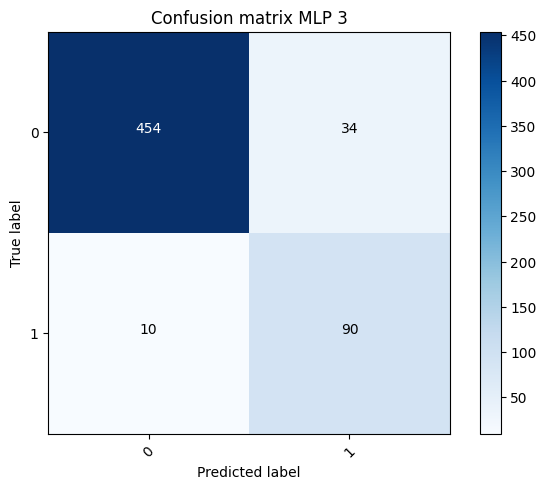

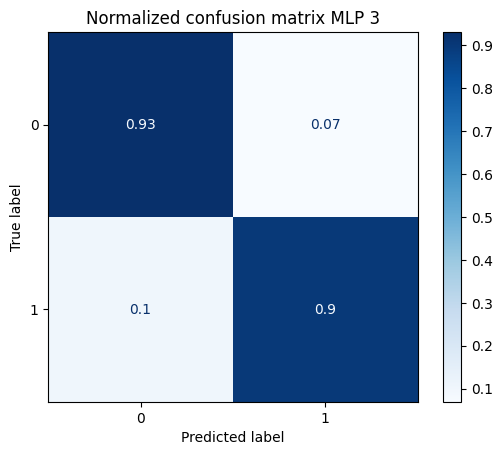

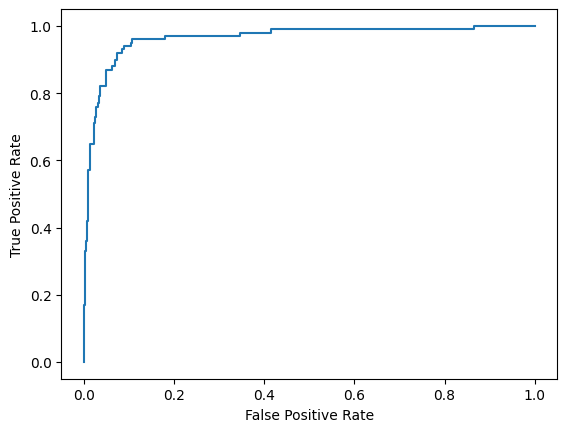

In [ ]:
evaluate(X_test, y_test, model3, '3') # the best

Test Loss: 0.31226933002471924
Test Accuracy: 0.9098639488220215
19/19 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       488
           1       0.67      0.93      0.78       100

    accuracy                           0.91       588
   macro avg       0.83      0.92      0.86       588
weighted avg       0.93      0.91      0.92       588

AUC: 0.9668647540983606
Sensitivity: 0.93
Specificity: 0.9057377049180327
Sum of performance metrics: 0.9255617439901391


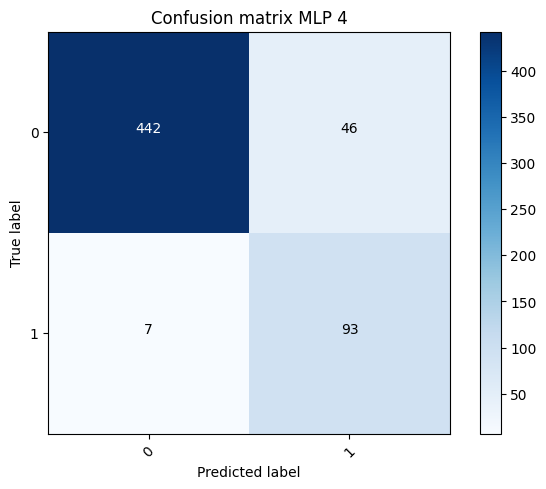

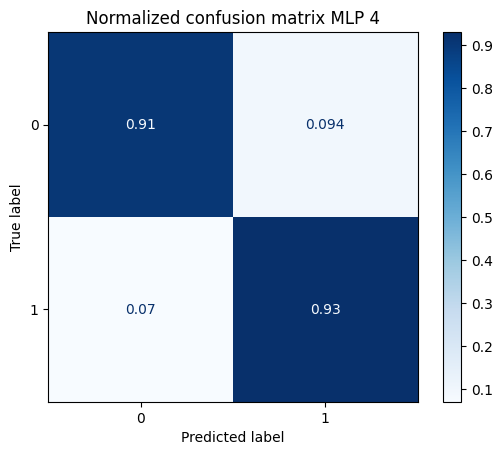

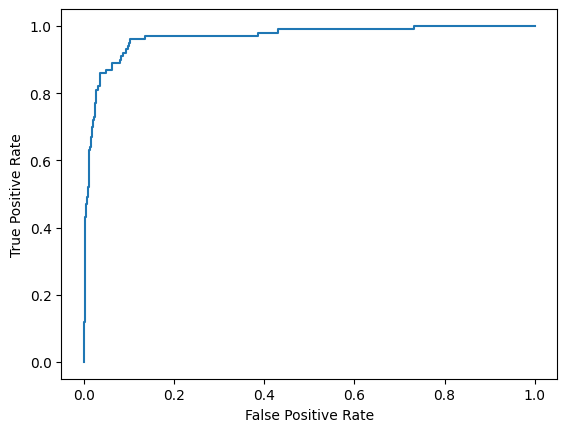

In [ ]:
evaluate(X_test, y_test, model4, '4')

Test Loss: 0.28968754410743713
Test Accuracy: 0.9081632494926453
19/19 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       488
           1       0.66      0.96      0.78       100

    accuracy                           0.91       588
   macro avg       0.82      0.93      0.86       588
weighted avg       0.93      0.91      0.91       588

AUC: 0.9673975409836064
Sensitivity: 0.96
Specificity: 0.8975409836065574
Sum of performance metrics: 0.929516033937935


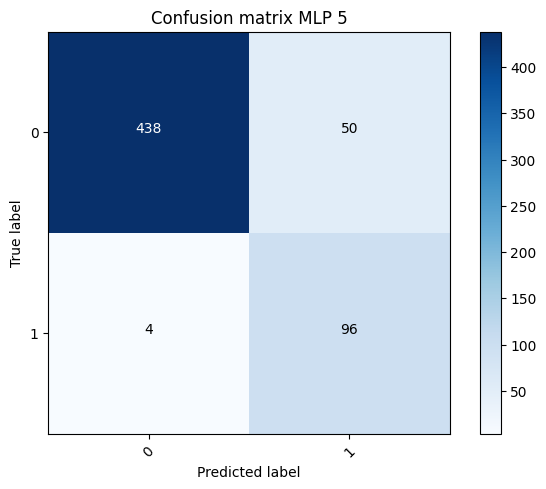

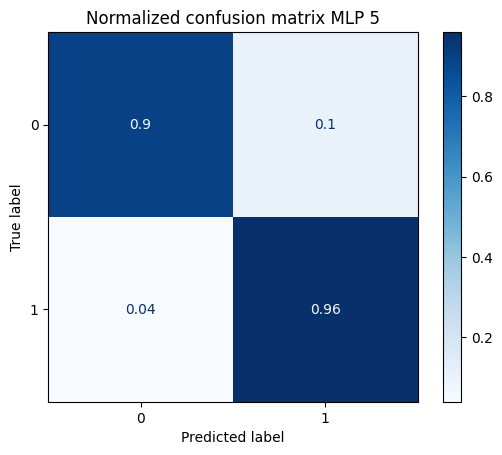

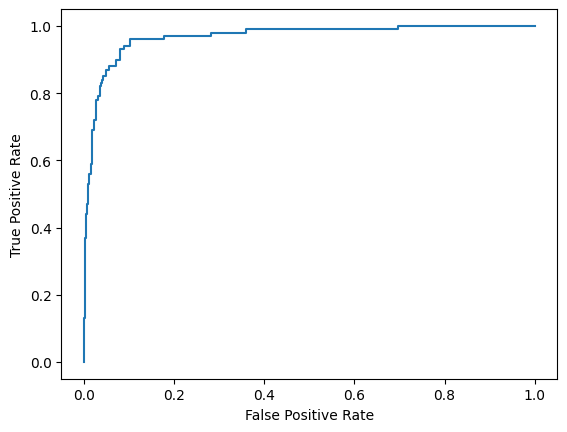

In [ ]:
evaluate(X_test, y_test, model5, '5')

# Method 2: *k*-NN

https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf


In [ ]:
X_train_am = X_train
y_train_am = y_train

X_test_am = np.concatenate((X_test,X_val), axis=0)
y_test_am = np.concatenate((y_test,y_val), axis=0)

Accuracy: 0.83
B. Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89       728
           1       0.51      0.85      0.64       150

    accuracy                           0.83       878
   macro avg       0.74      0.84      0.76       878
weighted avg       0.89      0.83      0.85       878

AUC: 0.9021336996336995
Sensitivity: 0.8533333333333334
Specificity: 0.8296703296703297
Average of performance metrics: 0.8534792097967525


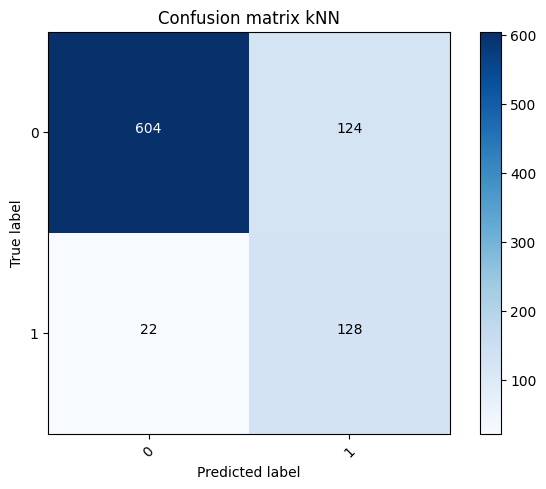

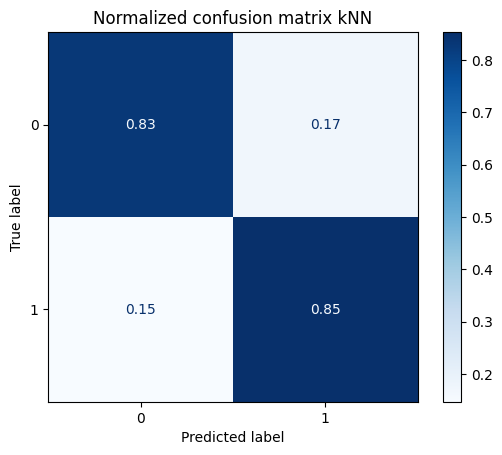

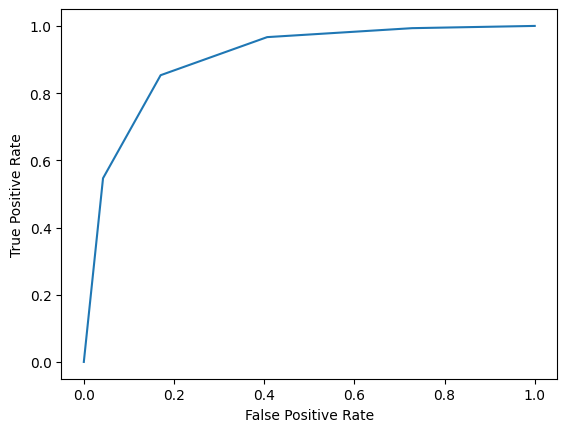

In [ ]:
kn = KNeighborsClassifier(n_neighbors=4)

kn.fit(X_train_am, y_train_am)

y_prob_kNN = kn.predict_proba(X_test_am)
y_pred_kNN = kn.predict(X_test_am)

print('Accuracy: %.2f' % accuracy_score(y_test_am, y_pred_kNN))
print('B. Accuracy: %.2f' % balanced_accuracy_score(y_test_am, y_pred_kNN))
print('Classification Report:\n', classification_report(y_test_am, y_pred_kNN))

cr = classification_report(y_test_am, y_pred_kNN, output_dict=True)

confusion_mtx = confusion_matrix(y_test_am, y_pred_kNN)

tn = confusion_mtx[0][0]
fp = confusion_mtx[0][1]
fn = confusion_mtx[1][0]
tp = confusion_mtx[1][1]

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
f1 = cr['weighted avg']['f1-score']
accuracy = cr['accuracy']

fpr2, tpr2, thresholds2 = roc_curve(y_test_am, y_prob_kNN[:,1])
auc2 = auc(fpr2,tpr2)

print('AUC:', auc2)
print('Sensitivity:', tp/(tp+fn))
print('Specificity:', tn/(tn+fp))
print('Average of performance metrics:',
      (accuracy+sensitivity+specificity+auc2+f1)/5)

plot_confusion_matrix(confusion_mtx, classes = (0,1), method="kNN")

disp = ConfusionMatrixDisplay.from_estimator(kn, X_test_am, y_test_am,
                                             display_labels=(0,1),
                                             cmap=plt.cm.Blues,
                                             normalize='true')
disp.ax_.set_title("Normalized confusion matrix kNN")

plt.savefig(f"{file_dir}//HIV-CP Plots/Normalized confusion matrix kNN.pdf")
plt.show()

plt.plot(fpr2,tpr2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Method 3: Logistic Regression

Accuracy: 0.91
B. Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       728
           1       0.66      0.92      0.77       150

    accuracy                           0.91       878
   macro avg       0.82      0.91      0.85       878
weighted avg       0.93      0.91      0.91       878

AUC: 0.9634615384615384
Sensitivity: 0.92
Specificity: 0.9024725274725275
Average of performance metrics: 0.8936385504560931


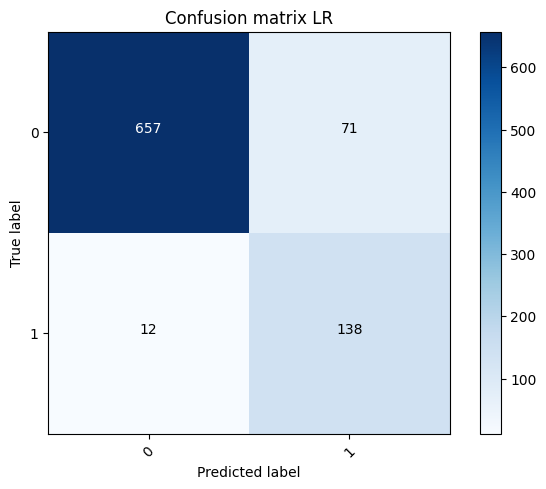

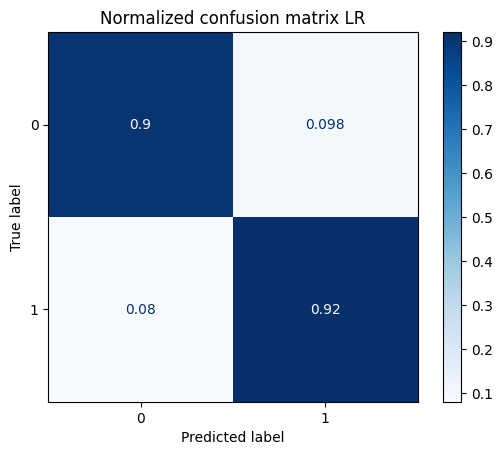

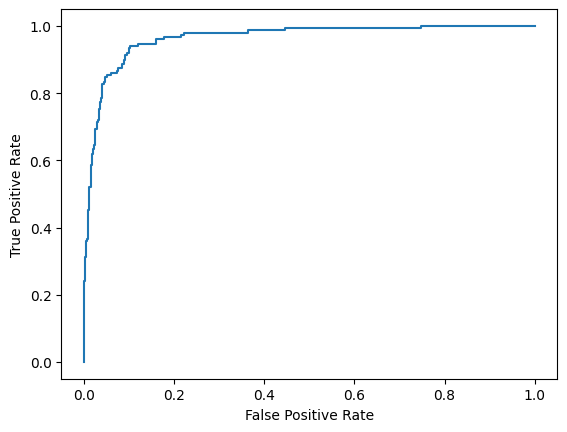

In [ ]:
lr = LogisticRegression(solver='lbfgs',
                        multi_class='ovr',
                        penalty='l2',
                        n_jobs=-1,
                        random_state=42)

lr.fit(X_train_am, y_train_am)

y_prob_lr = lr.predict_proba(X_test_am)
y_pred_lr = lr.predict(X_test_am)

print('Accuracy: %.2f' % accuracy_score(y_test_am, y_pred_lr))
print('B. Accuracy: %.2f' % balanced_accuracy_score(y_test_am, y_pred_lr))
print('Classification Report:\n', classification_report(y_test_am, y_pred_lr))

cr = classification_report(y_test_am, y_pred_kNN, output_dict=True)

confusion_mtx = confusion_matrix(y_test_am, y_pred_lr)

tn = confusion_mtx[0][0]
fp = confusion_mtx[0][1]
fn = confusion_mtx[1][0]
tp = confusion_mtx[1][1]

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
f1 = cr['weighted avg']['f1-score']
accuracy = cr['accuracy']

fpr3, tpr3, thresholds3 = roc_curve(y_test_am, y_prob_lr[:,1])
auc3 = auc(fpr3,tpr3)

print('AUC:', auc3)
print('Sensitivity:', tp/(tp+fn))
print('Specificity:', tn/(tn+fp))
print('Average of performance metrics:',
      (accuracy+sensitivity+specificity+auc3+f1)/5)

plot_confusion_matrix(confusion_mtx, classes = (0,1), method="LR")

disp = ConfusionMatrixDisplay.from_estimator(lr, X_test_am, y_test_am,
        display_labels=(0,1), cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Normalized confusion matrix LR")

plt.savefig(f"{file_dir}//HIV-CP Plots/Normalized confusion matrix LR.pdf")
plt.show()

plt.plot(fpr3,tpr3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
def compare_roccurves():
  plt.figure()
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')

  y_pred_MLP = model3.predict(X_test)
  fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_MLP)

  plt.plot(fpr1,tpr1)
  plt.plot(fpr2,tpr2)
  plt.plot(fpr3,tpr3)

  plt.legend(['MLP','kNN','LR'], frameon=False)
  plt.savefig(f"{file_dir}//HIV-CP Plots/ROC.pdf")

  plt.show()

19/19 [==============================] - 0s 2ms/step


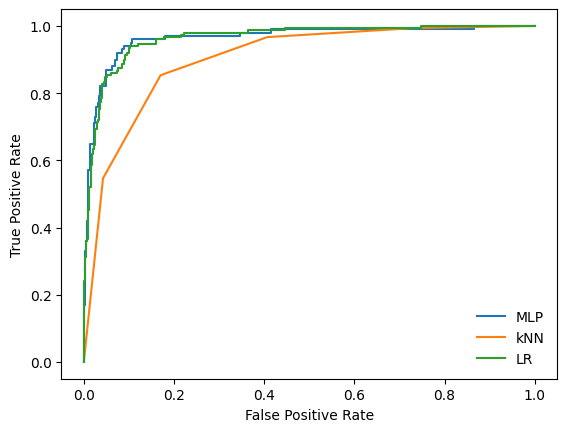

In [ ]:
compare_roccurves()